<a href="https://colab.research.google.com/github/springboardmentor442n-coder/TraceFinder/blob/Ishika-Sharma/TraceFinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import & Setup paths

In [26]:
import cv2
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from skimage.feature import canny
from skimage.measure import shannon_entropy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from tqdm import tqdm
from glob import glob

In [2]:
base_path = "/content/drive/MyDrive/TraceFinder"

flatfield_path = os.path.join(base_path, "Flatfield")
official_path = os.path.join(base_path, "Official")
originals_path = os.path.join(base_path, "Originals")
wiki_path = os.path.join(base_path, "Wikipedia")
tampered_path = os.path.join(base_path, "Tampered images")

In [3]:
# Verify
paths = {
    "flatfield": flatfield_path,
    "official": official_path,
    "originals": originals_path,
    "wikipedia": wiki_path,
    "tampered": tampered_path
}

for name, path in paths.items():
    print(f"{name}: {os.path.exists(path)} → {path}")

flatfield: True → /content/drive/MyDrive/TraceFinder/Flatfield
official: True → /content/drive/MyDrive/TraceFinder/Official
originals: True → /content/drive/MyDrive/TraceFinder/Originals
wikipedia: True → /content/drive/MyDrive/TraceFinder/Wikipedia
tampered: True → /content/drive/MyDrive/TraceFinder/Tampered images


In [4]:
for name, path in paths.items():
    print(f"\n{name.upper()} FILES:")
    for f in os.listdir(path):
        print(f)


FLATFIELD FILES:
HP
Canon120-2
EpsonV370-2
EpsonV370-1
Canon220
EpsonV550
EpsonV39-2
Canon9000-1
EpsonV39-1
Canon9000-2
Canon120-1

OFFICIAL FILES:
HP
EpsonV39-2
EpsonV39-1
EpsonV370-2
EpsonV550
Canon120-2
Canon220
Canon9000-2
Canon9000-1
Canon120-1

ORIGINALS FILES:
wikipedia
official

WIKIPEDIA FILES:
EpsonV370-2
EpsonV39-1
EpsonV370-1
Canon220
Canon120-2
Canon120-1
Canon9000-1
Canon9000-2

TAMPERED FILES:
Binary masks
Tampered


In [5]:
hp_path = "/content/drive/MyDrive/TraceFinder/Official/HP"

!ls "$hp_path"

150


## Load one sample image

In [6]:
sample_img_path = "/content/drive/MyDrive/TraceFinder/Official/HP/150/s11_13.tif"
img = cv2.imread(sample_img_path)

print("Loaded:", sample_img_path)

Loaded: /content/drive/MyDrive/TraceFinder/Official/HP/150/s11_13.tif


In [7]:
print("Shape:", img.shape)

Shape: (1727, 1240, 3)


## Show image using cv2 + matplotlib

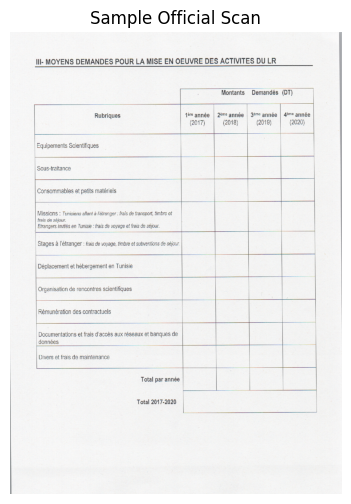

In [8]:
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Sample Official Scan")
plt.axis("off")
plt.show()

## Load All Folders Into a Dictionary

In [9]:
from glob import glob

# Dataset collector
datasets = {}

for name, path in paths.items():
    img_files = glob(os.path.join(path, "*"))
    datasets[name] = img_files
    print(f"{name}: {len(img_files)} folders")

flatfield: 11 folders
official: 10 folders
originals: 2 folders
wikipedia: 8 folders
tampered: 2 folders


## Function to load and process all datasets together

In [10]:
from PIL import Image
import numpy as np

# Image finder
def get_all_images(folder):
    """Return FULL PATHS of all .tif images inside a folder (recursively)."""
    image_paths = []
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(".tif"):
                image_paths.append(os.path.join(root, f))
    return image_paths

## Extract SCANNER LABEL from file path

In [11]:
import re

def get_scanner_label(path):
    scanners = [
        "HP",
        "EpsonV39", "EpsonV370", "EpsonV550",
        "Canon120", "Canon220", "Canon9000"
    ]

    for scanner in scanners:
        if scanner.lower() in path.lower():
            return scanner

    return "unknown"

## Feature Extraction Function

In [12]:
def extract_features(img_path):
    try:
        # Load TIFF image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # If image failed to load
        if img is None:
            print(f"[ERROR] Cannot read image: {img_path}")
            return None

        h, w = img.shape

        # File size
        file_size_kb = os.path.getsize(img_path) / 1024

        # Pixel count
        pixel_count = w * h

        # Basic intensity statistics
        mean_intensity = np.mean(img)
        std_intensity = np.std(img)

        # Flatten pixel values
        flat = img.flatten()

        # Return all features
        return {
            "width": w,
            "height": h,
            "aspect_ratio": w / h if h != 0 else 0,
            "file_size_kb": file_size_kb,
            "pixel_count": pixel_count,
            "mean_intensity": mean_intensity,
            "std_intensity": std_intensity,
            "skewness": skew(flat),
            "kurtosis": kurtosis(flat),
            "entropy": shannon_entropy(img)
        }

    except Exception as e:
        print(f"[EXCEPTION] While processing {img_path}: {e}")
        return None

## Process all datasets

In [13]:
rows = []

for category, folder_list in datasets.items():
    print(f"\nExtracting from: {category}")

    for folder in folder_list:
        img_list = get_all_images(folder)

        for img_path in img_list:
            features = extract_features(img_path)
            if features:
                features["category"] = category
                features["scanner"] = get_scanner_label(img_path)
                features["path"] = img_path
                rows.append(features)


Extracting from: flatfield
[ERROR] Cannot read image: /content/drive/MyDrive/TraceFinder/Flatfield/EpsonV39-1/._150.tif

Extracting from: official

Extracting from: originals

Extracting from: wikipedia

Extracting from: tampered


originals contains pdfs, hence 0 images found

In [14]:
# Create final dataframe
df = pd.DataFrame(rows)
print("\n======================")
print("FINAL DATAFRAME SHAPE:", df.shape)
print("======================")


FINAL DATAFRAME SHAPE: (393, 13)


In [15]:
df.head()

,width,height,aspect_ratio,file_size_kb,pixel_count,mean_intensity,std_intensity,skewness,kurtosis,entropy,category,scanner,path
0,2480,3503,0.707965,25458.733398,8687440,252.445602,0.763165,-0.968309,27.352556,1.601362,flatfield,HP,/content/drive/MyDrive/TraceFinder/Flatfield/H...
1,1240,1743,0.711417,6334.100586,2161320,253.779625,0.556954,-1.331429,22.814370,1.156102,flatfield,HP,/content/drive/MyDrive/TraceFinder/Flatfield/H...
2,2480,3508,0.706956,25495.067383,8699840,254.672265,7.990599,-25.875582,683.835031,0.039478,flatfield,Canon120,/content/drive/MyDrive/TraceFinder/Flatfield/C...
3,2480,3508,0.706956,25495.067383,8699840,254.673517,7.971760,-25.891490,684.619858,0.039313,flatfield,Canon120,/content/drive/MyDrive/TraceFinder/Flatfield/C...
4,2480,3508,0.706956,25495.073242,8699840,254.770624,2.829787,-30.809288,1222.515274,0.288385,flatfield,EpsonV370,/content/drive/MyDrive/TraceFinder/Flatfield/E...


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   width           393 non-null    int64  
 1   height          393 non-null    int64  
 2   aspect_ratio    393 non-null    float64
 3   file_size_kb    393 non-null    float64
 4   pixel_count     393 non-null    int64  
 5   mean_intensity  393 non-null    float64
 6   std_intensity   393 non-null    float64
 7   skewness        393 non-null    float64
 8   kurtosis        393 non-null    float64
 9   entropy         393 non-null    float64
 10  category        393 non-null    object 
 11  scanner         393 non-null    object 
 12  path            393 non-null    object 
dtypes: float64(7), int64(3), object(3)
memory usage: 40.0+ KB


## Scikit-Learn Models (Baseline)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import numpy as np

### Prepare Data

In [19]:
# Drop path column
df_model = df.drop(columns=["path", "category"])

# Encode label
le = LabelEncoder()
df_model["scanner_label"] = le.fit_transform(df_model["scanner"])

X = df_model.drop(columns=["scanner", "scanner_label"])
y = df_model["scanner_label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Train Random Forest Model

In [24]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)
print(classification_report(y_test, pred_rf, target_names=le.classes_))

              precision    recall  f1-score   support

    Canon120       0.62      0.62      0.62        13
    Canon220       0.62      0.67      0.64        12
   Canon9000       1.00      1.00      1.00        25
   EpsonV370       1.00      1.00      1.00         9
    EpsonV39       0.93      1.00      0.96        13
   EpsonV550       1.00      0.50      0.67         2
          HP       1.00      1.00      1.00         2
     unknown       1.00      0.67      0.80         3

    accuracy                           0.86        79
   macro avg       0.89      0.81      0.84        79
weighted avg       0.87      0.86      0.86        79



In [25]:
# Accuracy of model
accuracy = rf.score(X_test, y_test)
print(f"Random Forest Accuracy: {accuracy:.2f}")

Random Forest Accuracy: 0.86


<Figure size 800x600 with 0 Axes>

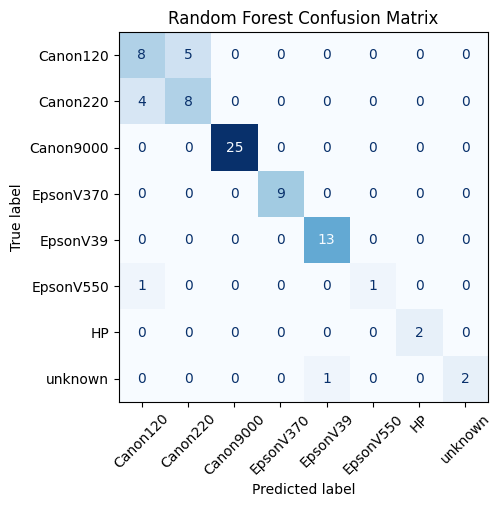

In [27]:
# Confusion Matrix
cm = confusion_matrix(y_test, pred_rf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
plt.figure(figsize=(8,6))
disp.plot(cmap="Blues", xticks_rotation=45, colorbar=False)
plt.title("Random Forest Confusion Matrix")
plt.show()

### Train Support Vector Classification Model

In [22]:
svm = SVC(kernel='rbf', C=2, gamma='scale')
svm.fit(X_train, y_train)

pred_svm = svm.predict(X_test)
print(classification_report(y_test, pred_svm, target_names=le.classes_))

              precision    recall  f1-score   support

    Canon120       0.44      0.54      0.48        13
    Canon220       0.25      0.17      0.20        12
   Canon9000       0.61      0.80      0.69        25
   EpsonV370       1.00      1.00      1.00         9
    EpsonV39       0.55      0.46      0.50        13
   EpsonV550       1.00      0.50      0.67         2
          HP       1.00      0.50      0.67         2
     unknown       0.00      0.00      0.00         3

    accuracy                           0.58        79
   macro avg       0.60      0.50      0.53        79
weighted avg       0.56      0.58      0.56        79



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
# Accuracy of model
accuracy = svm.score(X_test, y_test)
print(f"SVC Accuracy: {accuracy:.2f}")

SVC Accuracy: 0.58


<Figure size 800x600 with 0 Axes>

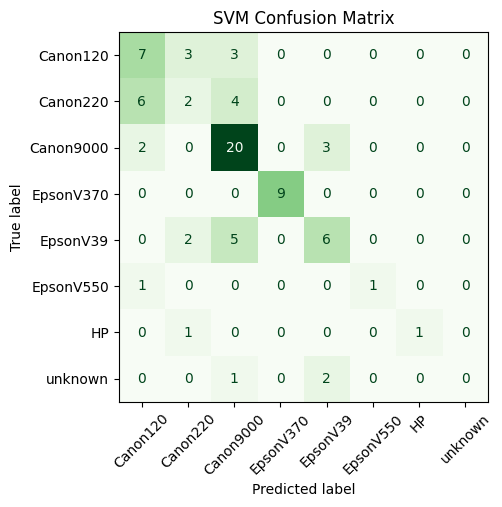

In [28]:
svm_pred = svm.predict(X_test)

cm = confusion_matrix(y_test, svm_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
plt.figure(figsize=(8,6))
disp.plot(cmap="Greens", xticks_rotation=45, colorbar=False)
plt.title("SVM Confusion Matrix")
plt.show()

## Simple CNN Model (Image Input)

In [47]:
df["scanner_label"] = le.fit_transform(df["scanner"])

### Generate Residuals

In [48]:
# required for scanner ID
from skimage.restoration import denoise_wavelet

def get_residual(img):
    den = denoise_wavelet(img, wavelet='db8', mode='soft', rescale_sigma=True)
    return img - den

In [49]:
# Build image dataset

import cv2
import numpy as np

IMG_SIZE = 256
X = []
Y = []

for idx, row in df.iterrows():
    img = cv2.imread(row["path"], cv2.IMREAD_GRAYSCALE)

    if img is None:
        continue

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)).astype("float32") / 255.0

    res = get_residual(img)
    res = (res - res.mean()) / (res.std() + 1e-8)  # normalize noise

    X.append(res.reshape(IMG_SIZE, IMG_SIZE, 1))
    Y.append(row["scanner_label"])

print("Image dataset shape:", images.shape)

Image dataset shape: (393, 128, 128, 1)


### Train-Test Split (CNN)

In [50]:
X = np.array(X)
Y = np.array(Y)

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

### Build a simple CNN Model

In [51]:
from tensorflow.keras import layers, models

simple_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    layers.MaxPool2D(2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D(2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPool2D(2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(len(le.classes_), activation='softmax')
])

simple_cnn.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [52]:
simple_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,432 (56.61 MB)

 Trainable params: 14,839,432 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train Simple CNN Model

In [53]:
history = simple_cnn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=16
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.1567 - loss: 10.8490 - val_accuracy: 0.3968 - val_loss: 1.7332
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.3207 - loss: 1.9144 - val_accuracy: 0.1429 - val_loss: 1.9543
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.3292 - loss: 1.7115 - val_accuracy: 0.5556 - val_loss: 1.6536
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.4788 - loss: 1.5165 - val_accuracy: 0.4603 - val_loss: 1.5021
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.6316 - loss: 1.1154 - val_accuracy: 0.6508 - val_loss: 1.5523
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.7702 - loss: 0.8631 - val_accuracy: 0.6032 - val_loss: 1.5269
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 0.8365 - loss: 0.5194 - val_accuracy: 0.6667 - val_loss: 1.4955
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.8497 - loss: 0.4764 - val_accuracy: 0.6667 - val_loss

### Evaluate CNN

In [54]:
pred = np.argmax(simple_cnn.predict(X_test), axis=1)
print(classification_report(y_test, pred, target_names=le.classes_))

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 954ms/step
              precision    recall  f1-score   support

    Canon120       0.78      0.54      0.64        13
    Canon220       0.67      0.33      0.44        12
   Canon9000       0.79      0.88      0.83        25
   EpsonV370       0.82      1.00      0.90         9
    EpsonV39       0.76      1.00      0.87        13
   EpsonV550       0.00      0.00      0.00         2
          HP       0.00      0.00      0.00         2
     unknown       0.25      0.33      0.29         3

    accuracy                           0.71        79
   macro avg       0.51      0.51      0.50        79
weighted avg       0.71      0.71      0.69        79



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training accuracy ↑ to 92%

Val accuracy ↓ to 66%

## Hybrid CNN Model

### Build Residual Dataset

In [68]:
# We extract noise residual using wavelet denoising
from skimage.restoration import denoise_wavelet

def get_residual(img):
    den = denoise_wavelet(img, wavelet='db8', mode='soft', rescale_sigma=True)
    return img - den

### What Is PRNU (Scanner Fingerprint)?

Every scanner sensor has tiny manufacturing imperfections.
These create unique, stable noise patterns across all scans:

1. Consistent grain
2. Pattern bias
3. Sensor fixed-pattern noise
4. High-frequency texture signature

This is called:

- Photo Response Non-Uniformity (PRNU)
- Also called device fingerprint, sensor noise pattern, etc.

PRNU is independent of image content, so even if two scanners scan the same document, their PRNU will differ.

Adding PRNU = huge boost in identification accuracy.

### PRNU (Photo Response Non-Uniformity)

Method from imaging forensics:

PRNU = (I - F(I)) / I
where:

I = original grayscale image

F(I) = denoised image (wavelet or BM3D)

In [69]:
def get_prnu(img):
    den = denoise_wavelet(img, wavelet="db8", mode="soft", rescale_sigma=True)
    prnu = (img - den) / (img + 1e-8)
    return prnu

### Combine Residual + PRNU (Better than simple CNN)

In [71]:
IMG_SIZE = 256
X, Y = [], []

for idx, row in df.iterrows():
    img = cv2.imread(row["path"], cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    # Resize and normalize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)).astype("float32") / 255.0

    # Extract residual and PRNU
    res = get_residual(img)
    prnu = get_prnu(img)

    # Normalize each channel
    res = (res - res.mean()) / (res.std() + 1e-8)
    prnu = (prnu - prnu.mean()) / (prnu.std() + 1e-8)

    # Combine both channels
    combined = np.stack([res, prnu], axis=-1)  # shape: (IMG_SIZE, IMG_SIZE, 2)
    X.append(combined)
    Y.append(row["scanner_label"])

In [72]:
X = np.array(X)
Y = np.array(Y)

In [73]:
# Encode labels
le = LabelEncoder()
Y = le.fit_transform(Y)
num_classes = len(le.classes_)

CNN input becomes 2-channel image, instead of 1

### Train-test split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

In [75]:
print(X_train.shape)

(314, 256, 256, 2)


### Build the CNN Feature Extractor

In [146]:
# It only extracts 256-dimensional scanner noise features

from tensorflow.keras import layers, models
from tensorflow.keras import regularizers

hybrid_cnn = models.Sequential([
    layers.Conv2D(32, (5,5), activation='relu', padding='same',
                  input_shape=(IMG_SIZE, IMG_SIZE, 2),
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPool2D(2),

    layers.Conv2D(64, (3,3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPool2D(2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPool2D(2),

    layers.Flatten(),
    layers.Dense(256, activation='relu', name="feature_layer",
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [147]:
# Stop training when validation accuracy stops improving
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

In [148]:
hybrid_cnn.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [149]:
hybrid_cnn.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_58 (Conv2D)              │ (None, 256, 256, 32)   │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_layer (Dense)           │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,650,728 (128.37 MB)

 Trainable params: 33,650,728 (128.37 MB)

 Non-trainable params: 0 (0.00 B)

### Train CNN (only for feature extraction)

In [150]:
history = hybrid_cnn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[early_stop]
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.2319 - loss: 9.0270 - val_accuracy: 0.1429 - val_loss: 2.0592
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 66s 4s/step - accuracy: 0.2797 - loss: 1.9852 - val_accuracy: 0.4127 - val_loss: 1.8200
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 67s 4s/step - accuracy: 0.3150 - loss: 1.8269 - val_accuracy: 0.4286 - val_loss: 1.8048
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.5008 - loss: 1.5442 - val_accuracy: 0.5079 - val_loss: 1.5938
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.5968 - loss: 1.3336 - val_accuracy: 0.5079 - val_loss: 1.6734
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.7802 - loss: 0.8785 - val_accuracy: 0.5238 - val_loss: 1.6859
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 104s 6s/step - accuracy: 0.8117 - loss: 0.7258 - val_accuracy: 0.5873 - val_loss: 1.5696
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 87s 6s/step - accuracy: 0.9253 - loss: 0.3860 - val_accuracy: 0.5873 - val_loss

### Extract Deep Features (remove final layer)

In [151]:
# Create a model to output the feature layer (moved here after training)
from tensorflow.keras import models

# Call hybrid_cnn on a single sample to ensure it is built before creating feature_model
_ = hybrid_cnn.predict(X_train[:1])

feature_model = models.Model(
    inputs=hybrid_cnn.input,
    outputs=hybrid_cnn.get_layer("feature_layer").output
)

# Extract features (moved here after training)
train_features = feature_model.predict(X_train)
test_features  = feature_model.predict(X_test)

print("Train features shape:", train_features.shape)
print("Test features shape:", test_features.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


AttributeError: The layer sequential_17 has never been called and thus has no defined input.

### Train ML Classifier on CNN Features

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42
)

rf.fit(train_features, y_train)
pred = rf.predict(test_features)

### Evaluate Hybrid CNN

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred, target_names=le.classes_))

### Confusion Matrix

In [ ]:
# Classification report
print(classification_report(y_test, pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Hybrid CNN + Random Forest Confusion Matrix")
plt.show()


## Save the Models

In [152]:
# Random Forest
import joblib

# Save the trained Random Forest
rf_model_path = "rf_model.pkl"
joblib.dump(rf, rf_model_path)
print(f"Random Forest model saved to {rf_model_path}")


# Save scaler
scaler_path = "scaler.pkl"
joblib.dump(scaler, scaler_path)

Random Forest model saved to rf_model.pkl


['scaler.pkl']

In [153]:
# Simple CNN
cnn_model_path = "simple_cnn_model.h5"
hybrid_cnn.save(cnn_model_path)
print(f"Simple CNN model saved to {cnn_model_path}")

Simple CNN model saved to simple_cnn_model.h5
